In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pylatexenc

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
#g = np.array([[0,1,1,0,1,1],
#              [1,0,1,0,0,0],
#              [1,1,0,1,0,1],
#              [0,0,1,0,1,1],
#              [1,0,0,1,0,1],
#              [1,0,1,1,1,0]])

#g = np.array([[0,1,1,0],
#              [1,0,1,1],
#              [1,1,0,1],
#              [0,1,1,0]])

g = np.array([[0,1,1],
              [1,0,1],
              [1,1,0]])

#g = np.array([[0,1,0,1,1],
#              [1,0,1,0,1],
#              [0,1,0,1,1],
#              [1,0,1,0,1],
#              [1,1,1,1,0]])

n_v = g.shape[0]
#HCP_korean = QuantumCircuit(n)

In [3]:
g_dict = {} # {edge: [vertex1, vertex2]}

edge_idx = 0
for i in range(n_v):
    for j in range(i, n_v):
        if g[i,j] == 1:
            g_dict[edge_idx] = [i, j]
            edge_idx += 1
n_e = edge_idx;
g_dict


{0: [0, 1], 1: [0, 2], 2: [1, 2]}

In [4]:
def oracle(qc, v0, v1, ev0, ev1, e, flag, n_v, n_e):
    for i in g_dict:
        qc.mcx([v0[g_dict[i][0]], v1[g_dict[i][0]]], ev0[i])
        qc.mcx([v0[g_dict[i][0]], ev0[i], e[i]], v1[g_dict[i][0]])
        qc.mcx([e[i], ev0[i]], v0[g_dict[i][0]])
        qc.mcx([v0[g_dict[i][1]], v1[g_dict[i][1]]], ev1[i])
        qc.mcx([v0[g_dict[i][1]], ev1[i], e[i]], v1[g_dict[i][1]])
        qc.mcx([e[i], ev1[i]], v0[g_dict[i][1]])
        #qc.barrier()
        
    temp = []
    for i in range(n_v):
        temp.append(v0[i])
        temp.append(v1[i])
    qc.x(v0)
    qc.mcx(temp, flag)
    qc.x(v0)
   # qc.barrier()
    
    for i in range(len(g_dict)-1, -1, -1):
        qc.mcx([e[i], ev1[i]], v0[g_dict[i][1]])
        qc.mcx([v0[g_dict[i][1]], ev1[i], e[i]], v1[g_dict[i][1]])
        qc.mcx([v0[g_dict[i][1]], v1[g_dict[i][1]]], ev1[i])
        qc.mcx([e[i], ev0[i]], v0[g_dict[i][0]])
        qc.mcx([v0[g_dict[i][0]], ev0[i], e[i]], v1[g_dict[i][0]])
        qc.mcx([v0[g_dict[i][0]], v1[g_dict[i][0]]], ev0[i])
        #qc.barrier()
    
    '''
    # encode    
    for i in g_dict:
        qc.cry(np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()
    
    # set flag
    qc.mcx(qr_v, qr_f)
    qc.barrier()

    # inverse
    for i in g_dict:
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()
    '''

def diffuser(qc, qr_e):
    qc.h(qr_e)
    qc.x(qr_e)
    qc.h(qr_e[-1])
    qc.mct(qr_e[:-1], qr_e[-1])#, ancilla_qubits=ancilla)
    qc.h(qr_e[-1])
    qc.x(qr_e)
    qc.h(qr_e)

In [5]:
def HCP_Grover(n_v, n_e):
    v0 = QuantumRegister(n_v, name='v0')
    v1 = QuantumRegister(n_v, name='v1')
    ev0 = QuantumRegister(n_e, name='ev0')
    ev1 = QuantumRegister(n_e, name='ev1')
    e = QuantumRegister(n_e, name='e')
    flag = QuantumRegister(1, name='flag')
    #n_anc = 32-n_v-n_e-1
    #anc = QuantumRegister(n_anc, name='anc')

    #c = ClassicalRegister(n_e)

    qc = QuantumCircuit(v0, v1, ev0, ev1, e, flag)
    '''
    qc.x(ev0)
    qc.x(ev1)
    qc.x(flag)
    qc.h(flag)
    qc.h(e)
    '''
    oracle(qc, v0, v1, ev0, ev1, e, flag, n_v, n_e)
    
    #qc.barrier()
    diffuser(qc, e)
    #qc.barrier()
    #qc.measure(e,c)
    return qc

In [6]:
Grover_ex = HCP_Grover(n_v,n_e)
'''
shots = 5120
qasm_sim = Aer.get_backend('qasm_simulator')
result = execute(Grover_ex, backend=qasm_sim, shots=shots).result()
count = result.get_counts()
hist = count
plot_histogram(count)
'''

"\nshots = 5120\nqasm_sim = Aer.get_backend('qasm_simulator')\nresult = execute(Grover_ex, backend=qasm_sim, shots=shots).result()\ncount = result.get_counts()\nhist = count\nplot_histogram(count)\n"

In [7]:
# Create controlled-Grover
grit = HCP_Grover(n_v,n_e).to_gate()
grit.label = "Grover"
cgrit = grit.control()

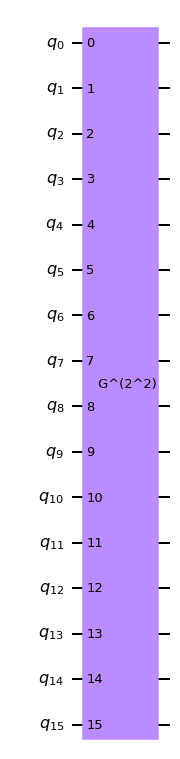

In [8]:
# Create certain orders of Grover's gates
# not used
def grover_orders(i,g):
    qc = QuantumCircuit(g)
    for j in range(2**i):
        qc.append(grit, range(g))
    
    return qc

# Test code for grover_orders(i,g):
g_i = grover_orders(2,3*n_e+2*n_v+1).to_gate()
g_i.label =' G^(2^%d)'%2

qc = QuantumCircuit(3*n_e+2*n_v+1)
qc.append(g_i, range(3*n_e+2*n_v+1))
qc.draw('mpl')


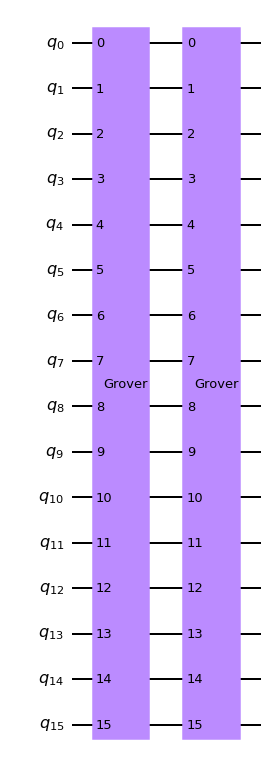

In [9]:
# duplicating gates, such as: G^2^2 * G^2^2 = G^2^3
def dupl_gates(g_in):
    n = g_in.num_qubits
    qc = QuantumCircuit(n)
    qc.append(g_in, range(n))
    qc.append(g_in, range(n))
    
    return qc

# Test code for dupl_gates(g_in)
g_0 = grit
g_1 = dupl_gates(g_0)
g_1.draw('mpl')

In [10]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [11]:
# Create QuantumCircuit
t = n_e +5   # no. of counting qubits
#n = 4   # no. of searching qubits

# Q reg.
T = QuantumRegister(t, name = 't')
V0 = QuantumRegister(n_v, name = 'v0')
V1 = QuantumRegister(n_v, name = 'v1')
EV0 = QuantumRegister(n_e, name = 'ev0')
EV1= QuantumRegister(n_e, name = 'ev1')
E = QuantumRegister(n_e, name = 'e')
flag = QuantumRegister(1, name = 'flag')
C = ClassicalRegister(t, name = 'c')

qc = QuantumCircuit(T, V0, V1, EV0, EV1, E, flag, C) # Circuit with n+t qubits and t classical bits

In [12]:
# Calculation of ifft operator
qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"

In [13]:
qc.x(EV0)
qc.x(EV1)
qc.x(flag)
qc.h(flag)
qc.h(E)
for qubit in range(0, t):
    qc.h(qubit)

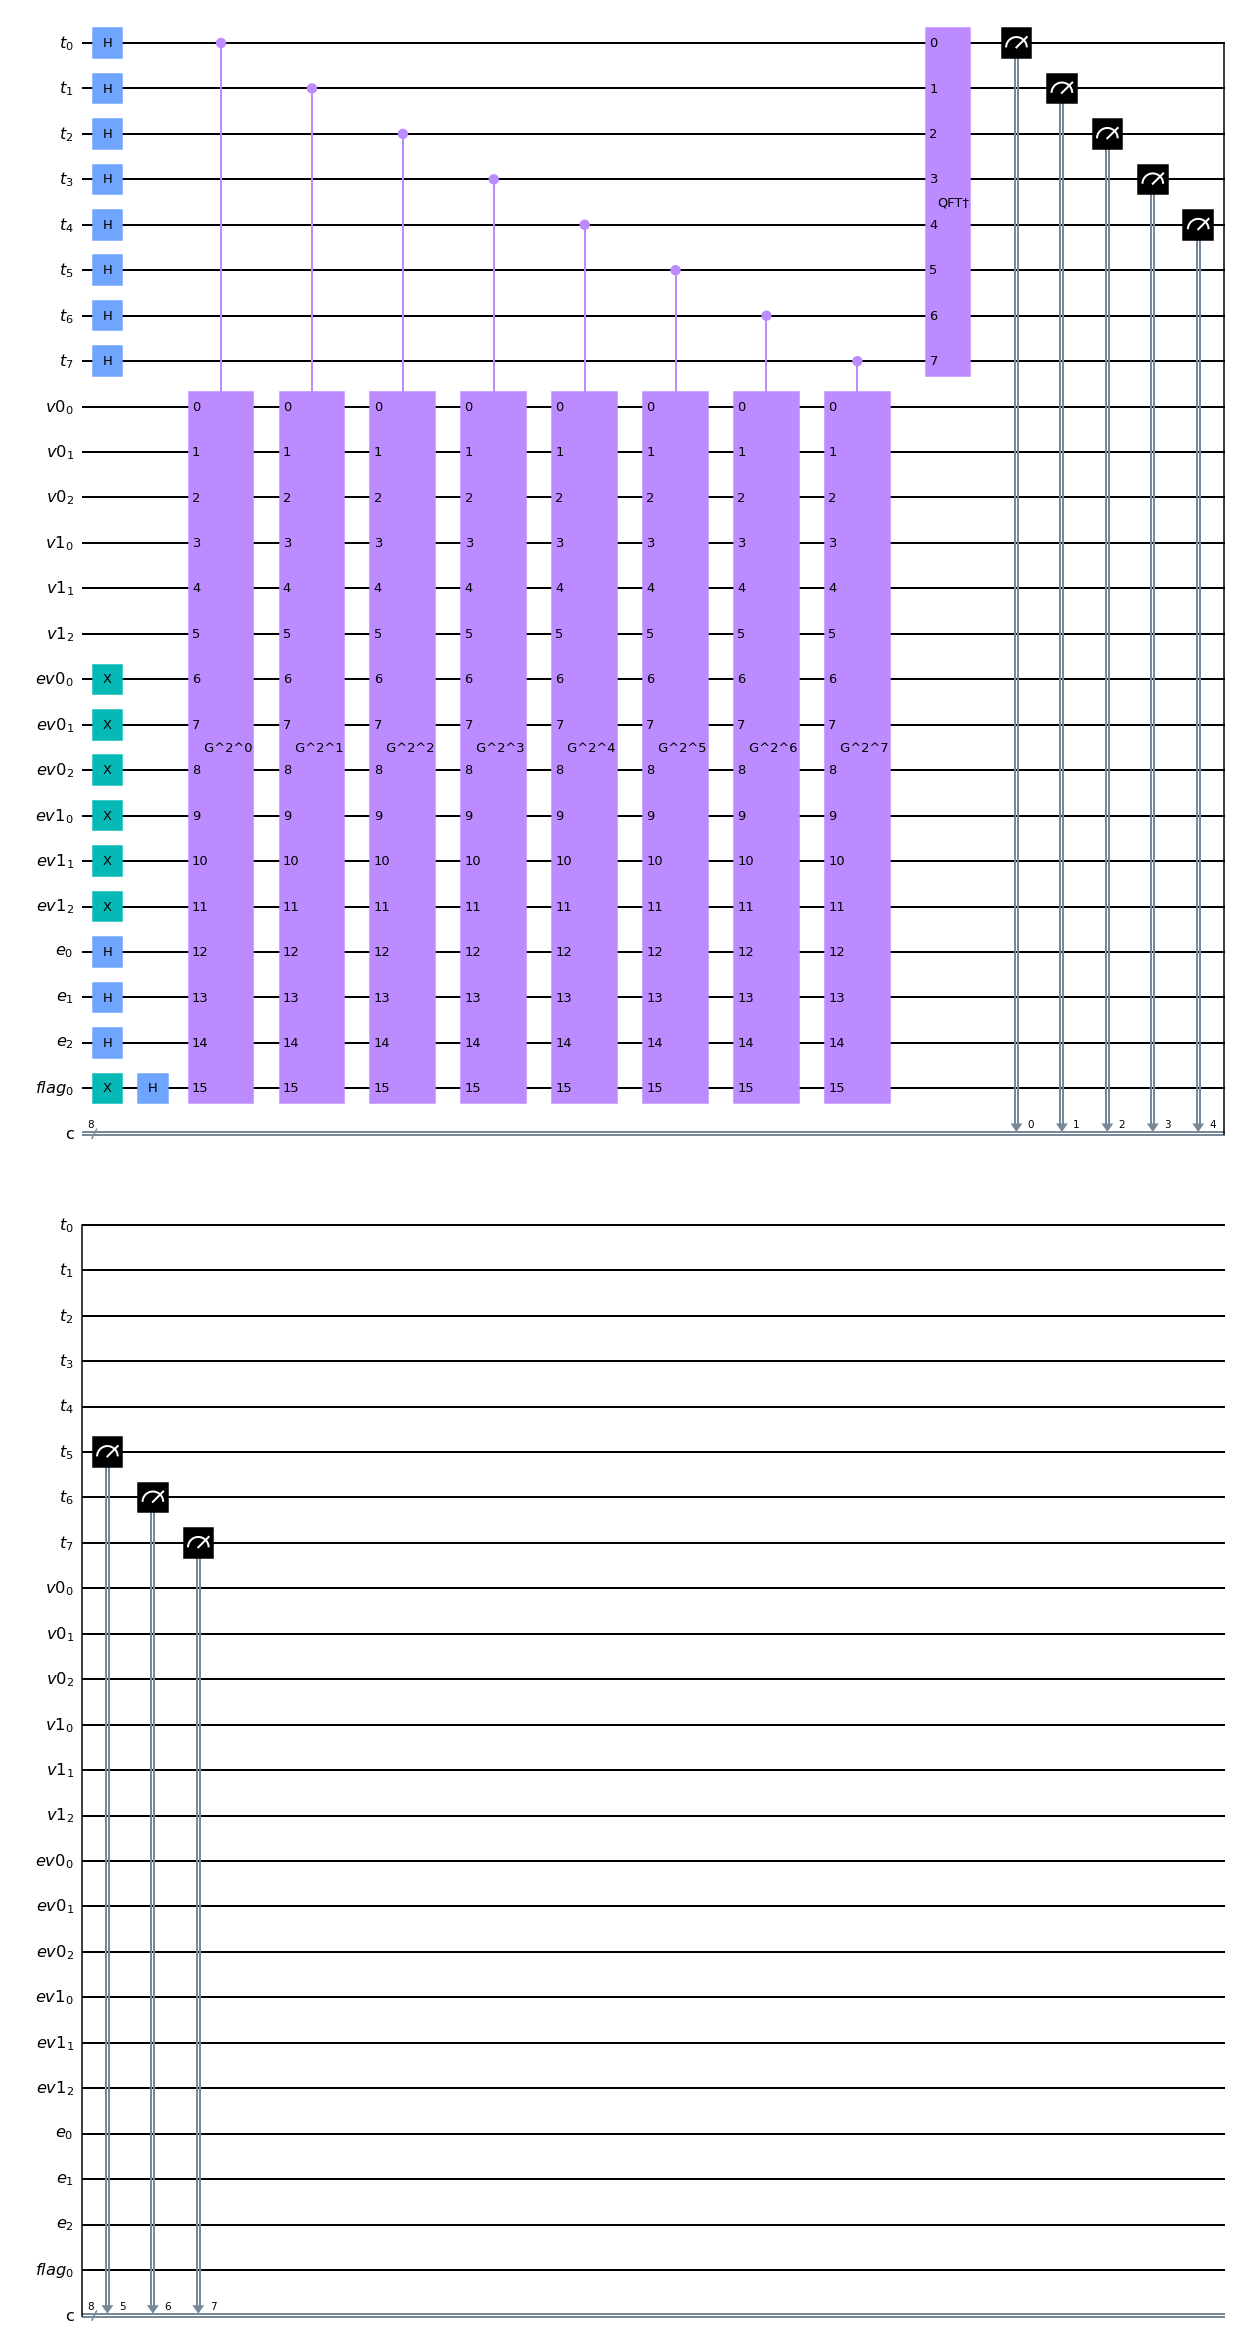

In [14]:
# Begin controlled Grover iterations
g_i_new = grit
for qubit in range(t):
    #for i in range(iterations):
    #   qc.append(cgrit, [qubit] + [*range(t, n+t)])
    #iterations *= 2
    
    g_i = g_i_new
    g_i.label =' G^2^%d'%qubit 
    cg_i = g_i.control()
    qc.append(cg_i, [qubit] + [*range(t, 2*n_v + 3*n_e + t +1)])
    
    # Duplicating g_i
    g_i_new = dupl_gates(g_i).to_gate()
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw('mpl')

In [14]:
#qc.qasm(formatted=True, filename = 'Q_counting_HCP.qasm_2')

OPENQASM 2.0;
include "qelib1.inc";
gate circuit-4250_dg q0,q1,q2,q3,q4,q5,q6,q7,q8,q9 { swap q4,q5; swap q3,q6; swap q2,q7; swap q1,q8; swap q0,q9; h q0; cp(-pi/2) q0,q1; h q1; cp(-pi/2) q1,q2; cp(-pi/4) q0,q2; h q2; cp(-pi/2) q2,q3; cp(-pi/4) q1,q3; cp(-pi/8) q0,q3; h q3; cp(-pi/2) q3,q4; cp(-pi/4) q2,q4; cp(-pi/8) q1,q4; cp(-pi/16) q0,q4; h q4; cp(-pi/2) q4,q5; cp(-pi/4) q3,q5; cp(-pi/8) q2,q5; cp(-pi/16) q1,q5; cp(-pi/32) q0,q5; h q5; cp(-pi/2) q5,q6; cp(-pi/4) q4,q6; cp(-pi/8) q3,q6; cp(-pi/16) q2,q6; cp(-pi/32) q1,q6; cp(-pi/64) q0,q6; h q6; cp(-pi/2) q6,q7; cp(-pi/4) q5,q7; cp(-pi/8) q4,q7; cp(-pi/16) q3,q7; cp(-pi/32) q2,q7; cp(-pi/64) q1,q7; cp(-pi/128) q0,q7; h q7; cp(-pi/2) q7,q8; cp(-pi/4) q6,q8; cp(-pi/8) q5,q8; cp(-pi/16) q4,q8; cp(-pi/32) q3,q8; cp(-pi/64) q2,q8; cp(-pi/128) q1,q8; cp(-pi/256) q0,q8; h q8; cp(-pi/2) q8,q9; cp(-pi/4) q7,q9; cp(-pi/8) q6,q9; cp(-pi/16) q5,q9; cp(-pi/32) q4,q9; cp(-pi/64) q3,q9; cp(-pi/128) q2,q9; cp(-pi/256) q1,q9; cp(-pi/512) q0,q9; h q9;

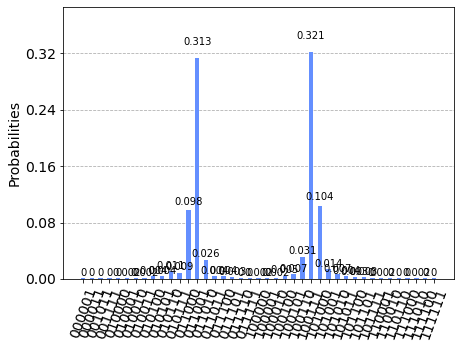

In [104]:
# Execute and see results
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
job = qasm_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

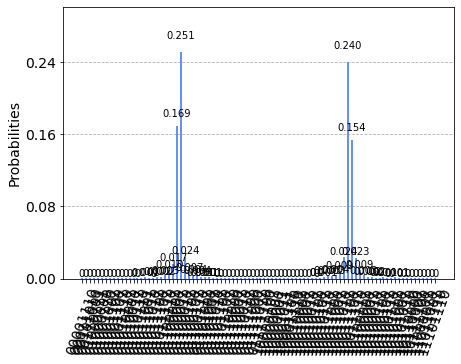

In [15]:
# Execute and see results 2
shots = 4096

qasm_sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_sim, shots=shots).result()
count = result.get_counts()
hist = count
plot_histogram(count)


In [16]:
count_sorted = sorted(count.items() ,key=lambda x:x[1], reverse=True)
for key,values in count_sorted:
    print(key,values)

01100011 1027
10011101 984
01100010 691
10011110 630
01100100 98
10011100 97
10011111 95
01100001 68
01100000 39
10100000 38
10011011 35
01100101 28
10011010 17
01100110 16
01100111 15
01011111 14
10100001 14
10011000 13
10011001 13
10100010 9
01011110 9
01011101 8
10100011 7
01011010 6
10101001 6
01101000 6
01101010 6
10100110 6
10010111 6
01101001 5
01011001 4
10100101 4
10100100 4
10010110 3
01011011 3
10010100 3
01101011 3
01101101 2
01111010 2
10100111 2
01001111 2
01110001 2
01011100 2
01110010 2
01001110 2
01101100 2
01111000 2
10010101 2
01010110 2
01110000 2
10001011 1
00001110 1
10001100 1
11000010 1
01111100 1
10010000 1
10010010 1
10101010 1
10010001 1
11011110 1
01000110 1
10001110 1
10101000 1
10000011 1
10101110 1
01110100 1
01010111 1
10000000 1
01000000 1
10110000 1
01111001 1
10001111 1
01010000 1
11101110 1
10110001 1
01001001 1
00011010 1
00101001 1
01001101 1
01001100 1
10111101 1
10111100 1
01111101 1
01110011 1
10000001 1
10010011 1
01010011 1
00110111 1
01101110

In [29]:
#get the string of the most probable result from our output dat
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 99


In [36]:
measured_int = int('10011110',2)
print(measured_int)

158


In [37]:
#get θ from measured_int 
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 3.87790


In [33]:
# get number of answer
N = 2**(n_e)
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.2f" % (N-M))

No. of Solutions = 0.97


In [28]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 0.08


NameError: name 'mcx' is not defined